In [39]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

In [40]:
NAIVE_RIDGE_PREDS_DIR = "naive_ridge_preds_maf_5e-2"
PRIOR_RIDGE_PREDS_DIR = "prior_ridge_preds_track=69,5110_maf=5e-2"

In [41]:
def compute_correlations(predictions_path: str, ground_truth_path: str):
    predictions_df = pd.read_csv(predictions_path, index_col=0)
    ground_truth_df = pd.read_csv(ground_truth_path, index_col=0)

    shared_samples = np.intersect1d(predictions_df.index, ground_truth_df.index)
    shared_genes = np.intersect1d(predictions_df.columns, ground_truth_df.columns)

    spearmans, pearsons, r2s = {}, {}, {}
    for gene in shared_genes:
        y_true = predictions_df.loc[shared_samples, gene]
        y_pred = ground_truth_df.loc[shared_samples, gene]
        spearmans[gene] = spearmanr(y_true, y_pred)[0]
        pearsons[gene] = pearsonr(y_true, y_pred)[0]
        r2s[gene] = r2_score(y_true, y_pred)
    return spearmans, pearsons, r2s

In [42]:
(
    all_samples_naive_spearmans,
    all_samples_naive_pearsons,
    all_samples_naive_r2s,
) = compute_correlations(
    os.path.join(NAIVE_RIDGE_PREDS_DIR, "all_predictions.csv"),
    os.path.join(NAIVE_RIDGE_PREDS_DIR, "all_ground_truth.csv"),
)

print(
    f"All samples, naive ridge, pearson: {np.median(list(all_samples_naive_pearsons.values()))}"
)
print(
    f"All samples, naive ridge, spearman: {np.median(list(all_samples_naive_spearmans.values()))}"
)
print(
    f"All samples, naive ridge, r2: {np.median(list(all_samples_naive_r2s.values()))}"
)

All samples, naive ridge, pearson: 0.24450079526965782
All samples, naive ridge, spearman: 0.24550968959077918
All samples, naive ridge, r2: -12.148263095081921


In [43]:
(
    yri_samples_naive_spearmans,
    yri_samples_naive_pearsons,
    yri_samples_naive_r2s,
) = compute_correlations(
    os.path.join(NAIVE_RIDGE_PREDS_DIR, "yri_predictions.csv"),
    os.path.join(NAIVE_RIDGE_PREDS_DIR, "yri_ground_truth.csv"),
)

print(
    f"YRI samples, naive ridge, pearson: {np.median(list(yri_samples_naive_pearsons.values()))}"
)
print(
    f"YRI samples, naive ridge, spearman: {np.median(list(yri_samples_naive_spearmans.values()))}"
)
print(
    f"YRI samples, naive ridge, r2: {np.median(list(yri_samples_naive_r2s.values()))}"
)

YRI samples, naive ridge, pearson: 0.1510997629679149
YRI samples, naive ridge, spearman: 0.14967654068777667
YRI samples, naive ridge, r2: -27.791657966569563


In [44]:
(
    all_samples_prior_spearmans,
    all_samples_prior_pearsons,
    all_samples_prior_r2s,
) = compute_correlations(
    os.path.join(PRIOR_RIDGE_PREDS_DIR, "all_predictions.csv"),
    os.path.join(PRIOR_RIDGE_PREDS_DIR, "all_ground_truth.csv"),
)

print(
    f"All samples, prior ridge, pearson: {np.median(list(all_samples_prior_pearsons.values()))}"
)
print(
    f"All samples, prior ridge, spearman: {np.median(list(all_samples_prior_spearmans.values()))}"
)
print(
    f"All samples, prior ridge, r2: {np.median(list(all_samples_prior_r2s.values()))}"
)

All samples, prior ridge, pearson: 0.2539455023704895
All samples, prior ridge, spearman: 0.25279932700180724
All samples, prior ridge, r2: -11.609536659703256


In [45]:
(
    yri_samples_prior_spearmans,
    yri_samples_prior_pearsons,
    yri_samples_prior_r2s,
) = compute_correlations(
    os.path.join(PRIOR_RIDGE_PREDS_DIR, "yri_predictions.csv"),
    os.path.join(PRIOR_RIDGE_PREDS_DIR, "yri_ground_truth.csv"),
)

print(
    f"YRI samples, prior ridge, pearson: {np.median(list(yri_samples_prior_pearsons.values()))}"
)
print(
    f"YRI samples, prior ridge, spearman: {np.median(list(yri_samples_prior_spearmans.values()))}"
)
print(
    f"YRI samples, prior ridge, r2: {np.median(list(yri_samples_prior_r2s.values()))}"
)

YRI samples, prior ridge, pearson: 0.1652056665870574
YRI samples, prior ridge, spearman: 0.1605890364317331
YRI samples, prior ridge, r2: -24.803719482807903


In [46]:
def compare_correlations(
    corrs1: dict, corrs2: dict, xlabel: str, ylabel: str, title: str, ax: plt.Axes
):
    genes = list(set(corrs1.keys()) & set(corrs2.keys()))
    corrs1_l = np.asarray([corrs1[g] for g in genes])
    corrs2_l = np.asarray([corrs2[g] for g in genes])

    n_corrs1_better = np.sum(corrs1_l >= corrs2_l)
    n_corrs2_better = np.sum(corrs2_l > corrs1_l)

    sns.scatterplot(x=corrs1_l, y=corrs2_l, s=20, alpha=0.5, ax=ax)
    ax.set_xlabel(xlabel + "\n" + rf"$\mu={np.mean(corrs1_l):.3f}$")
    ax.set_ylabel(ylabel + "\n" + rf"$\mu={np.mean(corrs2_l):.3f}$")
    ax.set_title(title)

    # Plot diagonal line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal")

    # Plot number of genes where each method is better
    pct_corrs1_better = n_corrs1_better / len(genes) * 100.0
    pct_corrs2_better = n_corrs2_better / len(genes) * 100.0
    ax.text(
        x=0.95,
        y=0.05,
        s=f"{n_corrs1_better}/{len(genes)} ({pct_corrs1_better:.1f}%)",
        c="red",
        transform=ax.transAxes,
        ha="right",
        va="bottom",
    )
    ax.text(
        x=0.05,
        y=0.95,
        s=f"{n_corrs2_better}/{len(genes)} ({pct_corrs2_better:.1f}%)",
        c="red",
        transform=ax.transAxes,
        ha="left",
        va="top",
    )

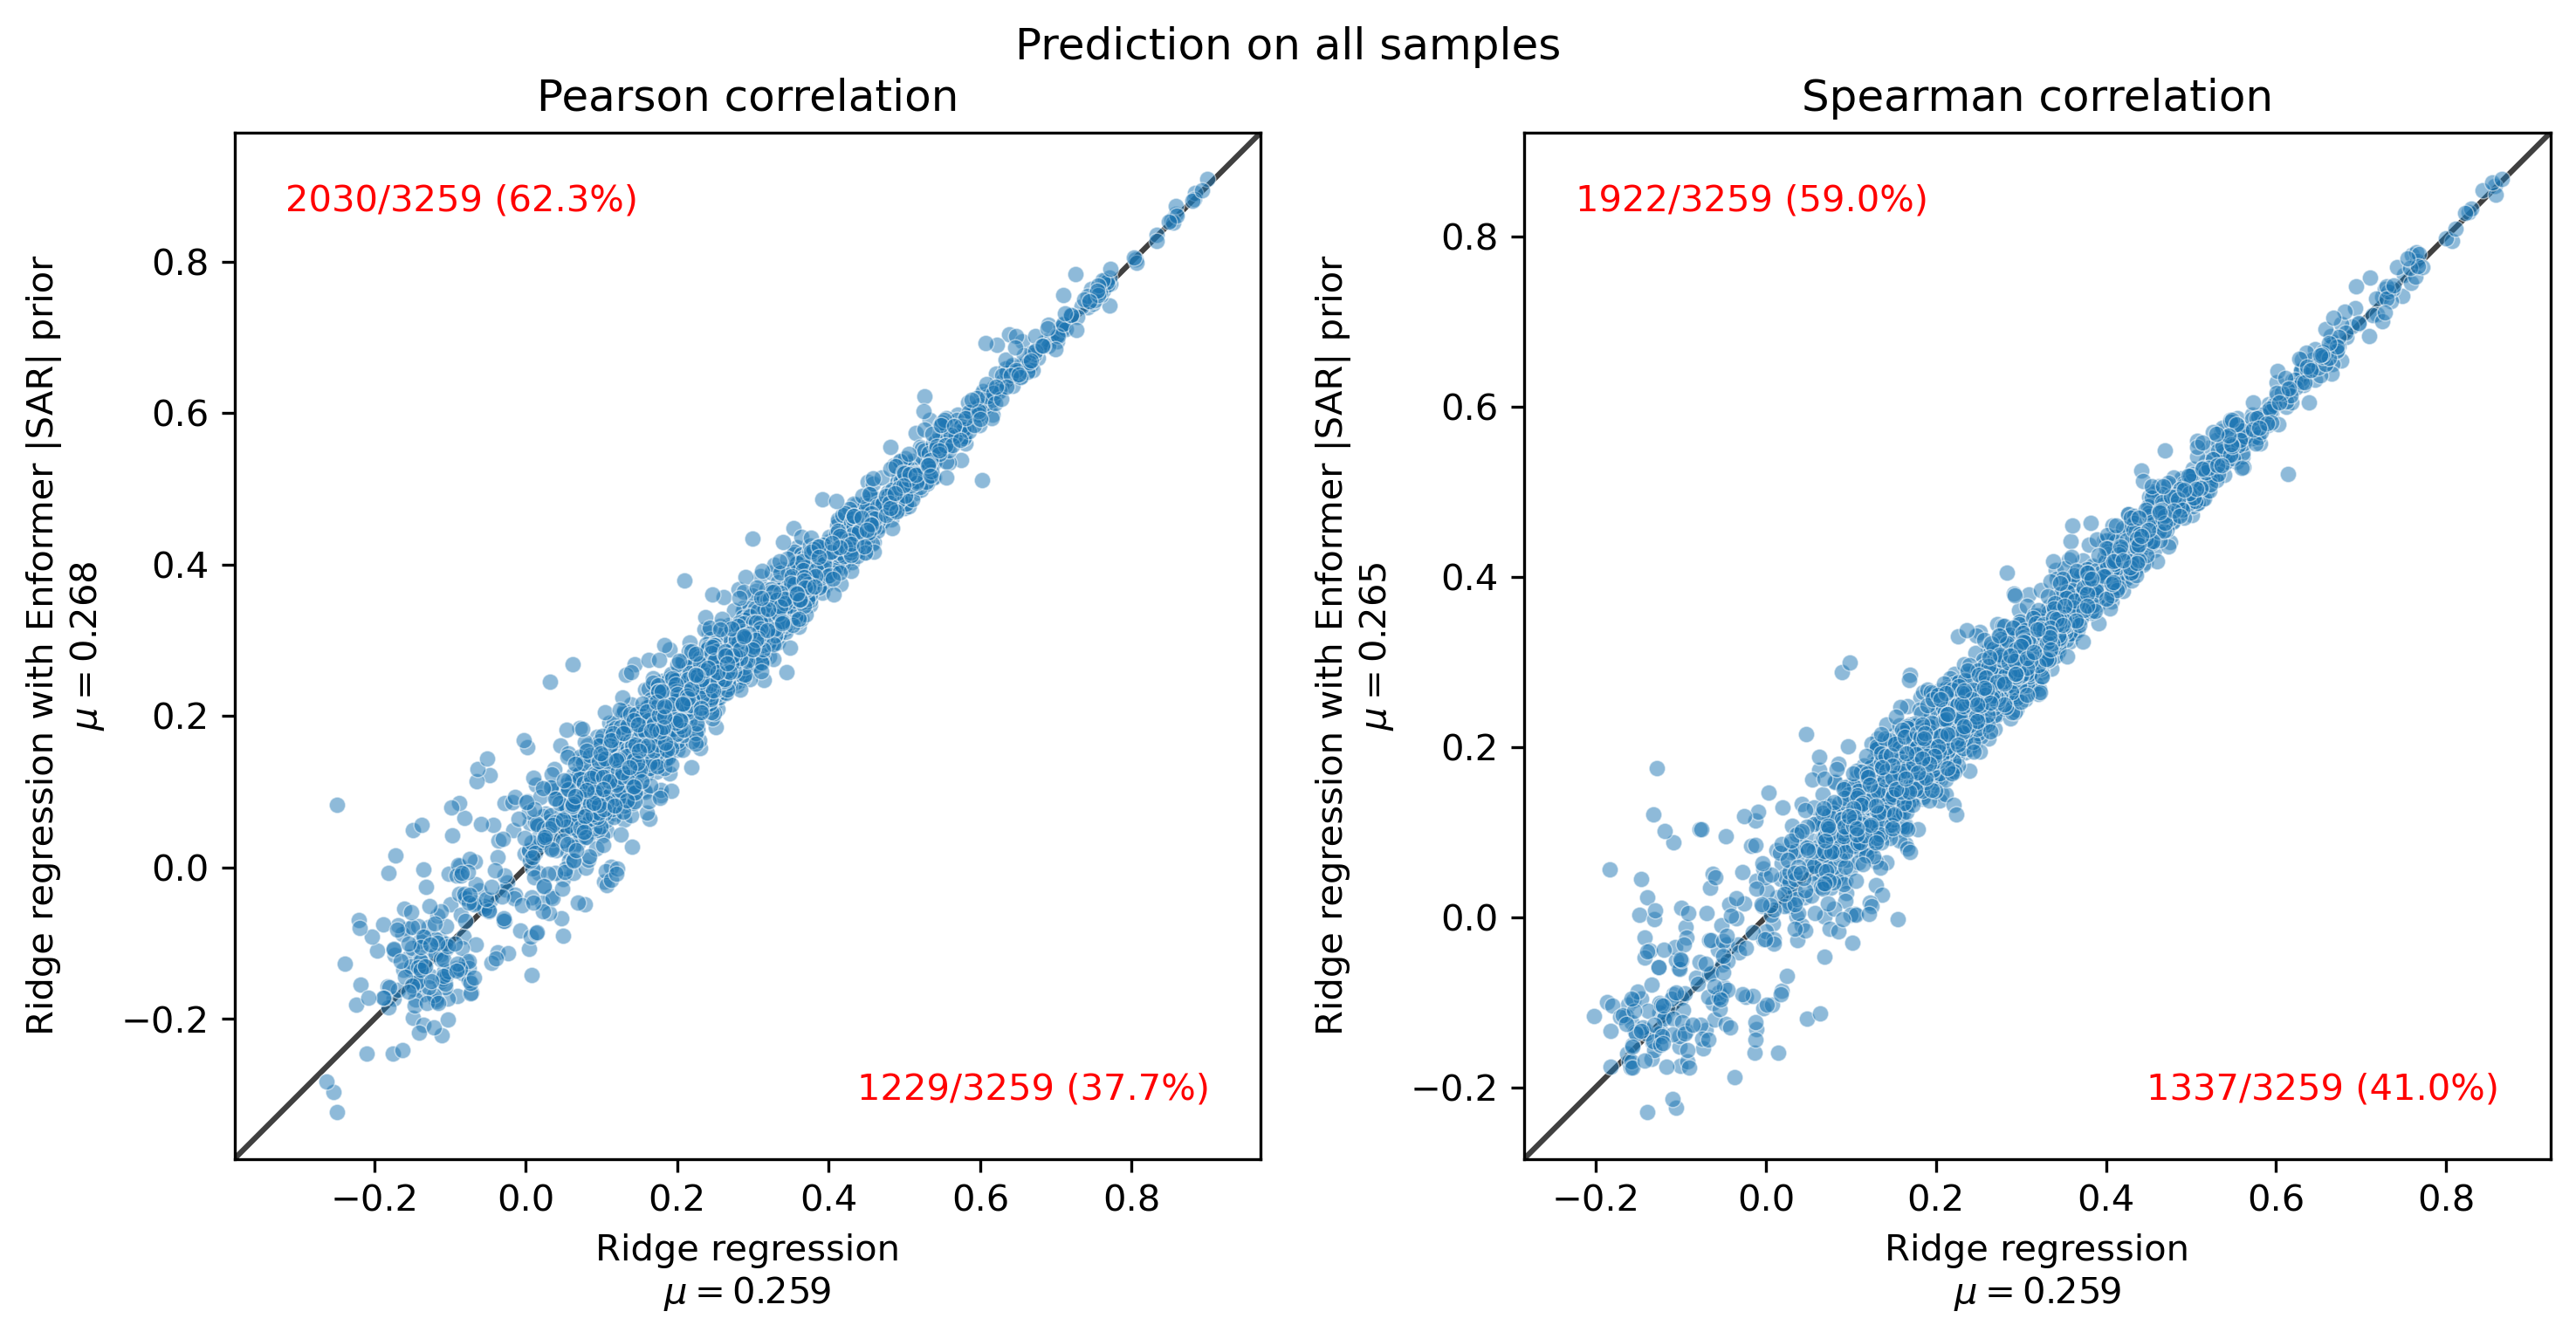

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), dpi=300)
compare_correlations(
    all_samples_naive_pearsons,
    all_samples_prior_pearsons,
    "Ridge regression",
    "Ridge regression with Enformer |SAR| prior",
    "Pearson correlation",
    axs[0],
)
compare_correlations(
    all_samples_naive_spearmans,
    all_samples_prior_spearmans,
    "Ridge regression",
    "Ridge regression with Enformer |SAR| prior",
    "Spearman correlation",
    axs[1],
)
plt.suptitle("Prediction on all samples")
plt.tight_layout()
plt.show()

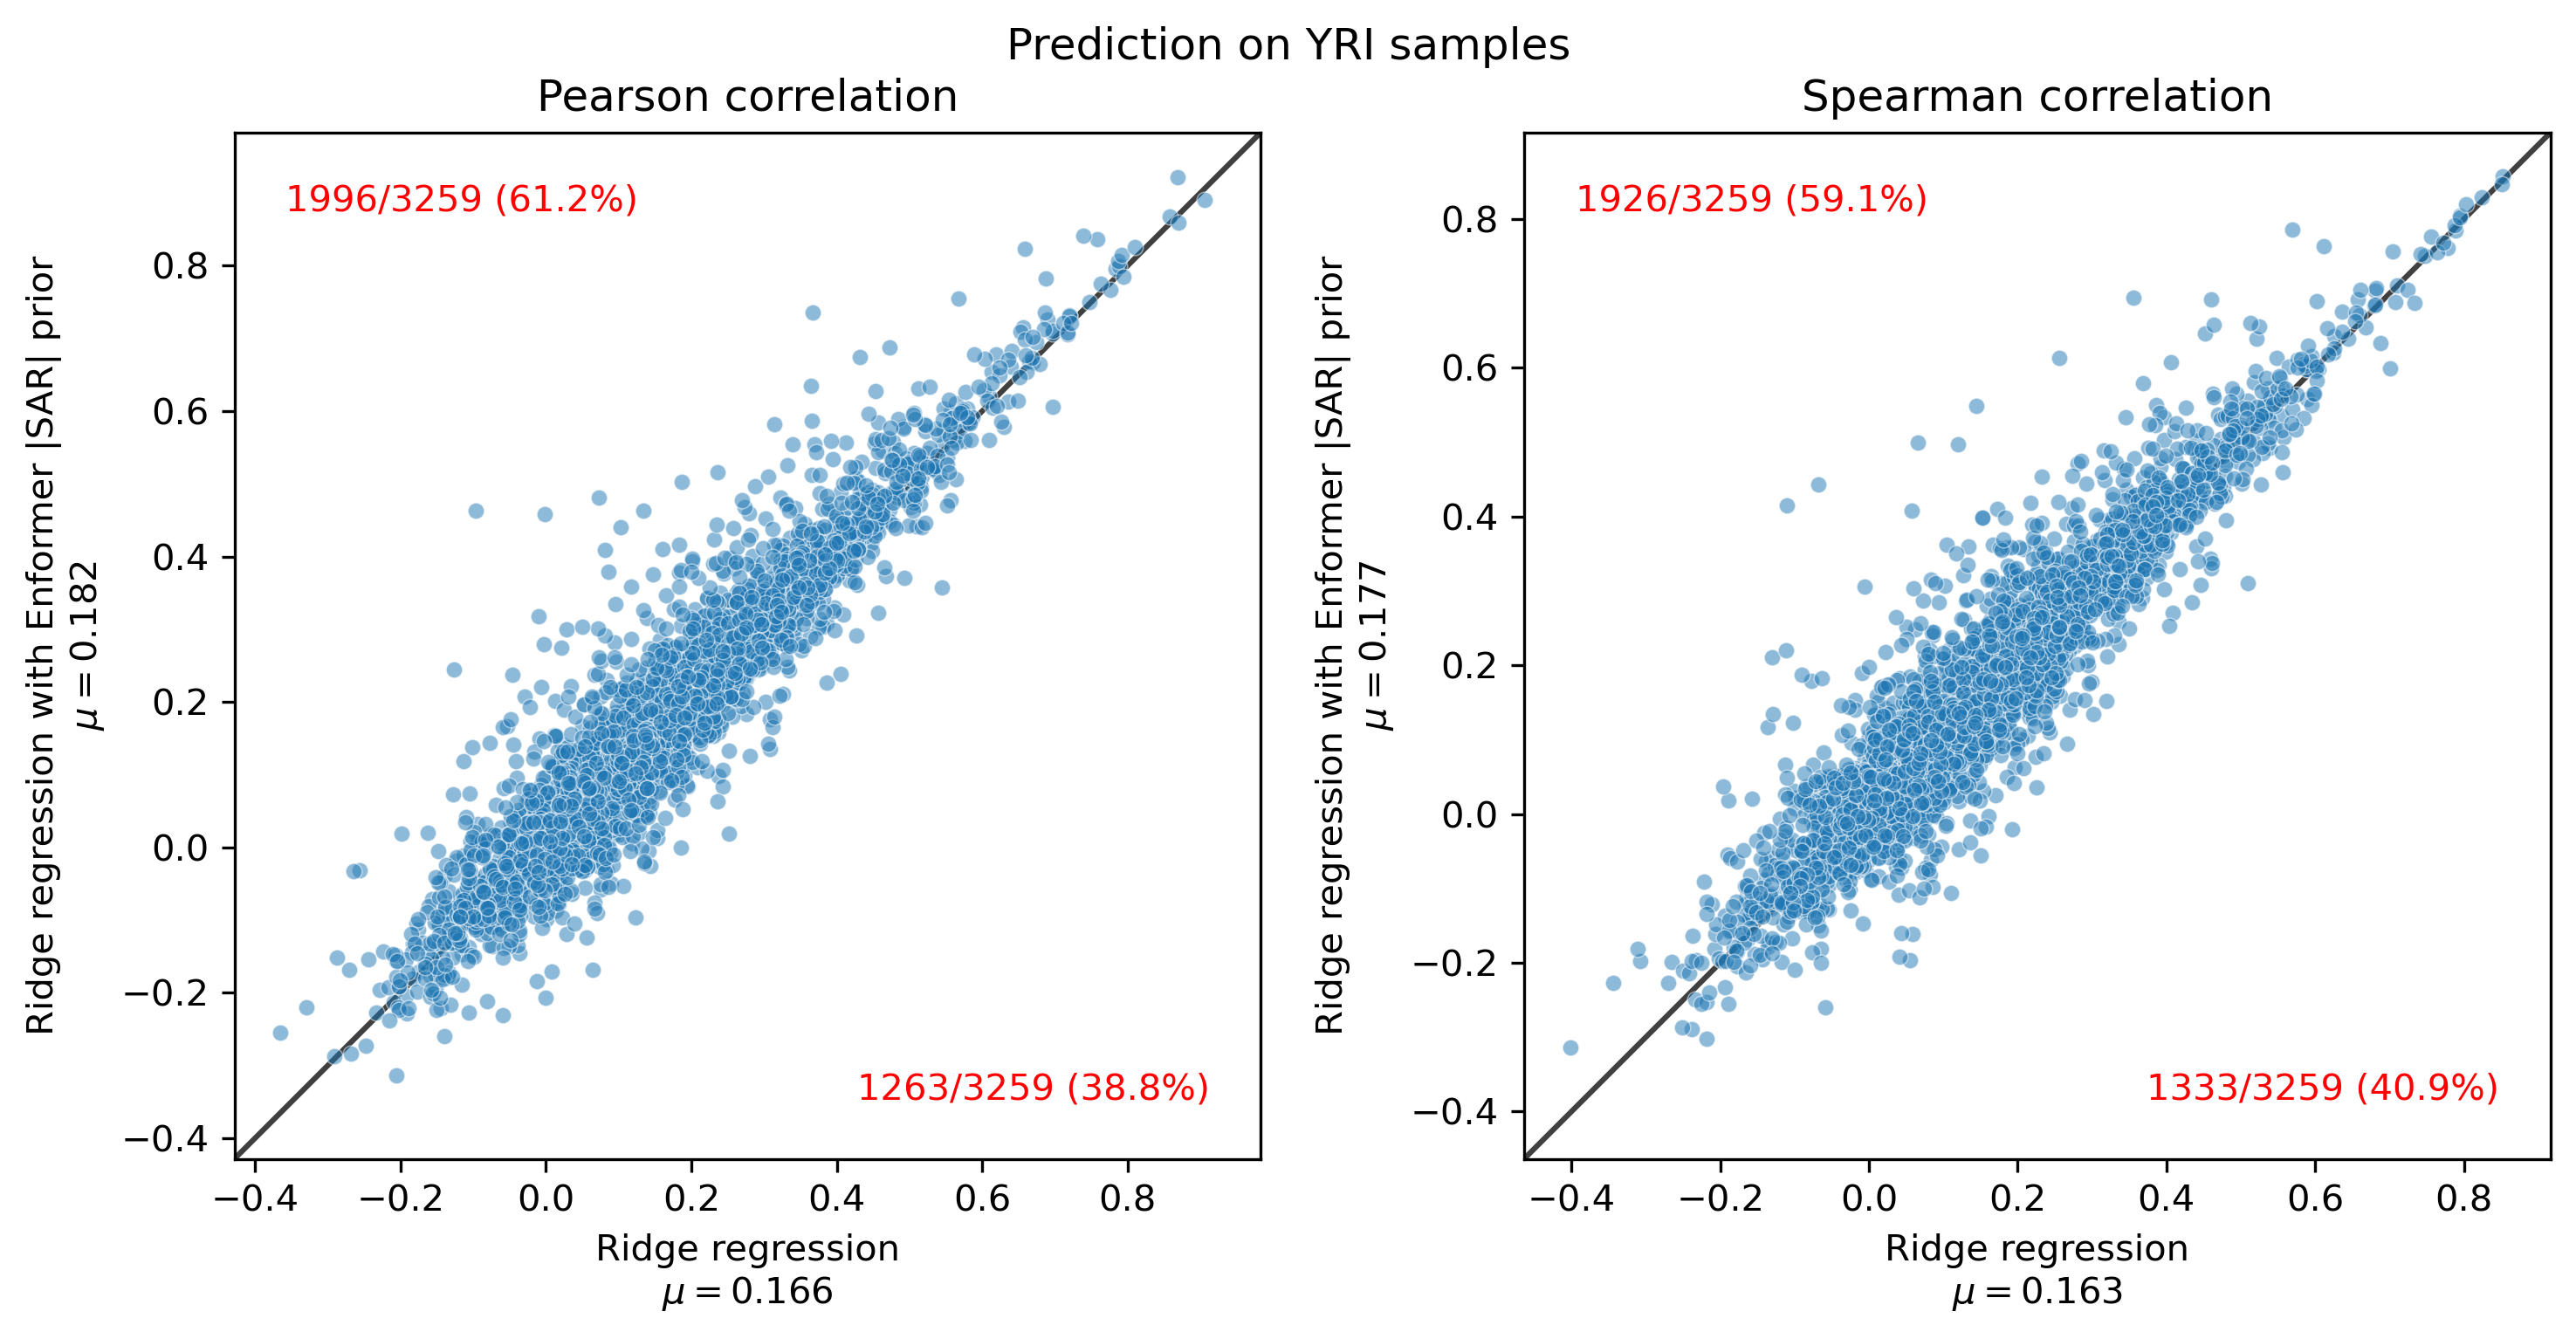

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), dpi=300)
compare_correlations(
    yri_samples_naive_pearsons,
    yri_samples_prior_pearsons,
    "Ridge regression",
    "Ridge regression with Enformer |SAR| prior",
    "Pearson correlation",
    axs[0],
)
compare_correlations(
    yri_samples_naive_spearmans,
    yri_samples_prior_spearmans,
    "Ridge regression",
    "Ridge regression with Enformer |SAR| prior",
    "Spearman correlation",
    axs[1],
)
plt.suptitle("Prediction on YRI samples")
plt.tight_layout()
plt.show()